In [1]:
import os
from control.matlab import ss, lsim, linspace, c2d
from PID import PID
from sim3 import vt,dc,ap
import matplotlib.pyplot as plt
import numpy as np
import time
import statistics

In [2]:
# you can use vt, dc and ap
a = vt()
print(a.sysd)
# a.ref = [0] * 251 + [2] * 250
# a.thres=6

A = [[0.84648172]]

B = [[0.09211097]]

C = [[1.]]

D = [[0.]]

dt = 0.02



In [3]:
#only for vt
control_inputs = []
measures=[]
x_just_before = 0
xout=1
pid = PID(P=a.p, I=a.i, D=a.d, current_time=0)
pid.setWindup(100)
pid.setSampleTime(a.Ts)
for i in range(0, a.slot+1):
    a.y_real_arr.append(a.yreal)
    # sensor attack here
    a.score.append(a.s)
    pid.SetPoint = a.ref[i]
    pid.update(feedback_value=a.ymeasure, current_time=i * a.Ts)
    a.cin = pid.output
#     print(a.ymeasure,i,a.cin,xout)
    if a.cin>5:
        a.cin=5
    elif a.cin<-5:
        a.cin = -5
    else:
        a.cin=a.cin
    control_inputs.append(a.cin)
    if i>a.place:
        if (a.score[-1]==a.thres):
            a.att=a.drift
        else:
            a.att = a.thres+a.drift-a.score[-1]
    
    yout, T, xout = lsim(a.sysc, a.cin, [0, a.Ts], a.ymeasure)
    ymax, T, xout1 = lsim(a.sysc, a.maxc, [0, a.Ts], a.ymeasure)
    yout2, T, xout2 = lsim(a.sysc, a.cin, [0, a.Ts], a.yreal)
    a.yreal=yout2[-1]
    ypred = yout[-1]
    a.ymeasure = yout[-1]-a.att
#     if i>a.place-1:
#         a.ymeasure = min(ymax[-1],yout[-1]-a.att)
#         print(a.ymeasure,a.cin)
    a.s = a.score[-1]+abs(ypred-a.ymeasure)-a.drift
    if(a.s<0):
        a.s=0
    if(i==a.place+1):
        x_just_before = xout
    measures.append(a.ymeasure)

# print(control_inputs[a.place+2:])
# print(a.score[a.place+2:])
# print(x_just_before)


In [4]:
# ---------------------------------------
max_k = 450
attack_inputs = control_inputs[a.place+2:]
print('attack_inputs=', attack_inputs)
for j in range(0, len(attack_inputs)-10):
    temp = attack_inputs[j:j+10]
    if 5 in temp or 5 in temp:
        continue
    vari = statistics.variance(temp)
    print(vari, end= ' ')
    if(vari < 1e-6):
        max_k = j
        break
print('max_k', max_k)

attack_inputs = np.array([control_inputs[a.place+2:]])
x_just_before = x_just_before[-1]
print(x_just_before, len(x_just_before.shape))
if len(x_just_before.shape) == 0:
    x_a = np.array([[x_just_before]])
else:
    x_a = np.array([[item] for item in x_just_before])
# def get_safetime(self, x_a, safe_set_lo, safe_set_up, control_list: np.array, max_k)
safe_set_lo = a.safeset['lo']
safe_set_up = a.safeset['up']
k = a.est.get_safetime(x_a, safe_set_lo, safe_set_up, attack_inputs, max_k)
print(k)

# ---------------------------------------
        


attack_inputs= [1.6666725064903742, 5, 5, 5, 5, 5, 5, 4.862332517356338, 4.786998639049702, 4.786998639049702, 4.578899029148652, 4.578899029148652, 4.370839361894953, 4.370839361894953, 4.172713289453148, 4.172713289453148, 3.990295496189999, 3.990295496189999, 3.8264845703077857, 3.8264845703077857, 3.6822248333060177, 3.6822248333060177, 3.557181534251689, 3.557181534251689, 3.4502281416178286, 3.4502281416178286, 3.35979177031078, 3.35979177031078, 3.284092572206534, 3.284092572206534, 3.221304765195524, 3.221304765195524, 3.169660509029703, 3.1468089074409002, 3.1468089074409002, 3.1089993436336165, 3.1089993436336165, 3.0784769077186747, 3.0784769077186747, 3.0540097873491137, 3.0540097873491137, 3.034531733762302, 3.034531733762302, 3.0191318277473984, 3.0191318277473984, 3.007040619730115, 3.007040619730115, 2.997614640193391, 2.997614640193391, 2.990320618636561, 2.9870832994790253, 2.9870832994790253, 2.9822337282919618, 2.9822337282919618, 2.978562147230217, 2.97856214723021

C:\Users\Mengyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


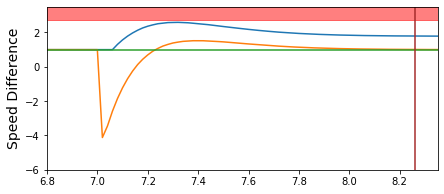

In [5]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.set_ylim(-6,3.5)
ax.set_xlim(6.8,8.35)
ax.plot(a.t_arr, a.y_real_arr,label='real')
ax.plot(a.t_arr, measures,label='measure')
ax.plot(a.t_arr, a.ref,label='ref')
ax.axhspan(2.7, 3.5, color='r', alpha=0.5)
ax.axvline((a.place+2+k)*a.Ts, color='brown',label='stable')
ax.set_ylabel('Speed Difference', fontsize=14)
# ax.legend()
fig.show()
# fig.savefig('vt_unsafe_ref.pdf',bbox_inches='tight')
fig.savefig('vt_safe.pdf',bbox_inches='tight')
# fig.savefig('vt_unsafe_thres.pdf',bbox_inches='tight')

In [18]:
# you can use vt, dc and ap
a = dc()
print(a.sysd)
# a.ref = [0] * 251 + [2] * 250
# a.thres=6

A = [[  0.     1.     0.  ]
 [  0.   -10.     1.  ]
 [  0.    -0.02  -2.  ]]

B = [[0.]
 [0.]
 [2.]]

C = [[1. 0. 0.]]

D = [[0.]]



In [19]:
#for ap and dc
control_inputs = []
measures = []
x_just_before = 0
pid = PID(P=a.p, I=a.i, D=a.d, current_time=0)
pid.setWindup(100)
pid.setSampleTime(a.Ts)
for i in range(0, a.slot+1):
    a.y_real_arr.append(a.yreal)
    # sensor attack here
    a.score.append(a.s)
    pid.SetPoint = a.ref[i]
#     print(a.ymeasure,i * a.Ts)
    pid.update(feedback_value=a.ymeasure, current_time=i * a.Ts)
    a.cin = pid.output

    if a.cin>5:
        a.cin=5
    elif a.cin<-5:
        a.cin = -5
    else:
        a.cin=a.cin
    control_inputs.append(a.cin)
    if i>a.place:
        if (a.score[-1]==a.thres):
            a.att=a.drift
        else:
            a.att = a.thres+a.drift-a.score[-1]
            x_just_before = xout 
    yout, T, xout = lsim(a.sysd, a.cin, [0, a.Ts], a.xmeasure)
    yout2, T, xout2 = lsim(a.sysd, a.cin, [0, a.Ts], a.xreal)
    a.yreal=yout2[-1]
    ypred = yout[-1]
    a.xmeasure = xout[-1, :].T
    a.xreal = xout2[-1, :].T
    a.ymeasure = yout[-1]-a.att
#     if i>a.place:
#         a.ymeasure = min(ymax[-1],yout[-1]-a.att)
    a.s = a.score[-1]+abs(ypred-a.ymeasure)-a.drift
    if(a.s<0):
        a.s=0
    measures.append(a.ymeasure)
#waht you need
# print(control_inputs)
# print(x_just_before)

In [20]:
# ---------------------------------------
max_k = 450
attack_inputs = control_inputs[a.place+2:]
print('attack_inputs=', attack_inputs)
for j in range(0, len(attack_inputs)-10):
    temp = attack_inputs[j:j+10]
    if 20 in temp or 20 in temp:
        continue
    vari = statistics.variance(temp)
    print(vari, end= ' ')
    if(vari < 1e-6):
        max_k = j
        break
print('max_k', max_k)

attack_inputs = np.array([control_inputs[a.place+2:]])
x_just_before = x_just_before[-1]
print(x_just_before, len(x_just_before.shape))
if len(x_just_before.shape) == 0:
    x_a = np.array([[x_just_before]])
else:
    x_a = np.array([[item] for item in x_just_before])
# def get_safetime(self, x_a, safe_set_lo, safe_set_up, control_list: np.array, max_k)
safe_set_lo = a.safeset['lo']
safe_set_up = a.safeset['up']
k = a.est.get_safetime(x_a, safe_set_lo, safe_set_up, attack_inputs, max_k)
print(k)

# ---------------------------------------
        


attack_inputs= [5, -5, 5, 5, 5, 5, 5, 5, 5, 4.422306367603205, 3.288003791659262, 2.3592643446723267, 1.6596374981227324, 1.6596374981227324, 0.6560249706724284, 0.5081456443039489, 0.3616069438621392, 0.27097443003600374, 0.27097443003600374, 0.09178502717494363, 0.09178502717494363, 0.05775702905450497, 0.08708593147506294, 0.08708593147506294, 0.04701086860373682, 0.04701086860373682, 0.02757726155176271, 0.02757726155176271, 0.016835863654676667, 0.017497293366129863, 0.017497293366129863, 0.00834552152220593, 0.00834552152220593, 0.004191017459619539, 0.004400282328119114, 0.004400282328119114, 0.0019519044845108854, 0.0019519044845108854, 0.0010737819635335691, 0.0012526084825115321, 0.0012526084825115321, 0.0006031098452827801, 0.0006031098452827801, 0.00033529203075421585, 0.0003647662940760058, 0.0003647662940760058, 0.00017130339929050152, 0.00017130339929050152, 9.181891031872954e-05, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,

C:\Users\Mengyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


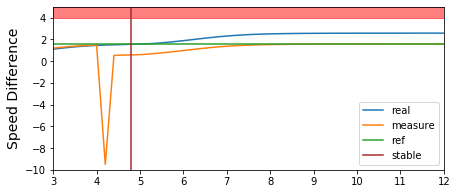

In [21]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.set_ylim(-10,5)
ax.set_xlim(3,12)
ax.plot(a.t_arr, a.y_real_arr,label='real')
ax.plot(a.t_arr, measures,label='measure')
ax.plot(a.t_arr, a.ref,label='ref')
ax.axhspan(4, 5, color='r', alpha=0.5)
ax.axvline((a.place+2+k)*a.Ts, color='brown',label='stable')
ax.set_ylabel('Speed Difference', fontsize=14)
ax.legend()
fig.show()
# fig.savefig('vt_unsafe_ref.pdf',bbox_inches='tight')
fig.savefig('dc_safe.pdf',bbox_inches='tight')
# fig.savefig('vt_unsafe_thres.pdf',bbox_inches='tight')

In [10]:
len(a.ref)

121

In [11]:
len(a.y_real_arr)

121